# Identifying Hate Speech Detection in Twitter

## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import re
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
%matplotlib inline

# Download NLTK resources
#nltk.download('stopwords')
#nltk.download('punkt')

## Loading Dataset

In [2]:
# Load the dataset
df = pd.read_csv('twitter.csv')  
print("Dataset loaded successfully.")

Dataset loaded successfully.


In [3]:
# Printing Dataset
df

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...,...,...,...,...,...
24778,25291,3,0,2,1,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779,25292,3,0,1,2,2,"you've gone and broke the wrong heart baby, an..."
24780,25294,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...
24781,25295,6,0,6,0,1,youu got wild bitches tellin you lies


In [4]:
df["labels"] = df["class"].map({0:"Hate Speech",
                                         1:"Offensive Language",
                                         2:"No Hate or Offensive Language"})

In [5]:
df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet,labels
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...,No Hate or Offensive Language
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,Offensive Language
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,Offensive Language
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,Offensive Language
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,Offensive Language


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          24783 non-null  int64 
 1   count               24783 non-null  int64 
 2   hate_speech         24783 non-null  int64 
 3   offensive_language  24783 non-null  int64 
 4   neither             24783 non-null  int64 
 5   class               24783 non-null  int64 
 6   tweet               24783 non-null  object
 7   labels              24783 non-null  object
dtypes: int64(6), object(2)
memory usage: 1.5+ MB


In [7]:
df = df[['tweet','labels']]
df.head()

,tweet,labels
0,!!! RT @mayasolovely: As a woman you shouldn't...,No Hate or Offensive Language
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,Offensive Language
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,Offensive Language
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,Offensive Language
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,Offensive Language


In [8]:
df['labels'].value_counts()

Offensive Language               19190
No Hate or Offensive Language     4163
Hate Speech                       1430
Name: labels, dtype: int64

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tweet   24783 non-null  object
 1   labels  24783 non-null  object
dtypes: object(2)
memory usage: 387.4+ KB


## Data Visualization

<Axes: xlabel='labels', ylabel='count'>

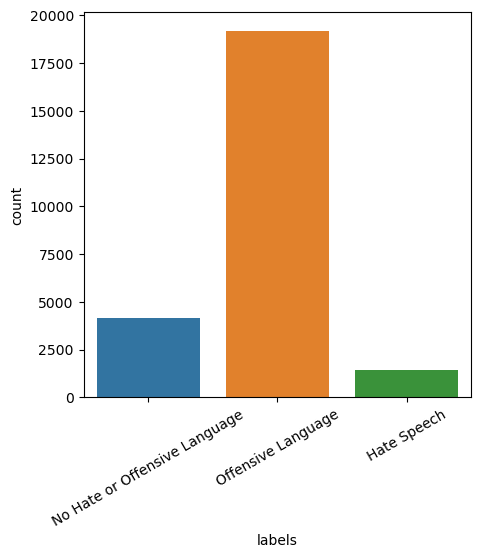

In [10]:
fig = plt.figure(figsize=(5,5))
plt.xticks(rotation=30)
sns.countplot(x='labels', data = df)

Text(0.5, 1.0, 'Distribution of sentiments')

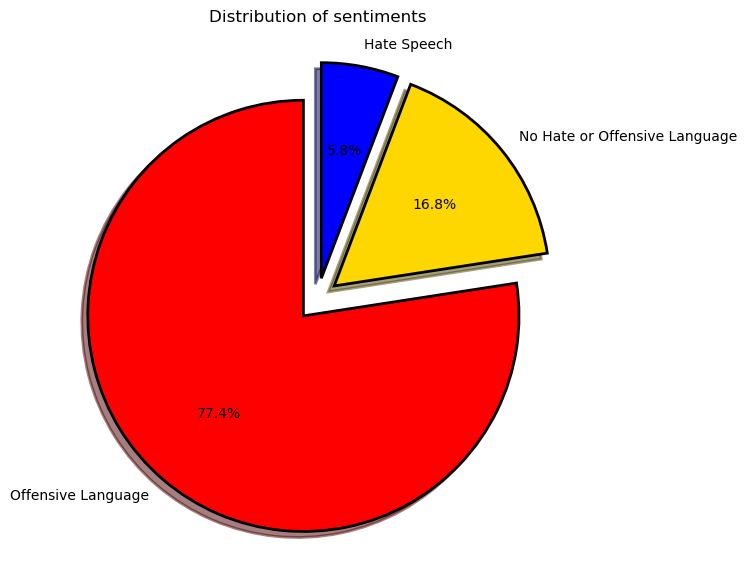

In [11]:
fig = plt.figure(figsize=(7,7))
colors = ("red", "gold", "blue")
wp = {'linewidth':2, 'edgecolor':"black"}
tags = df['labels'].value_counts()
explode = (0.1, 0.1, 0.1)
tags.plot(kind='pie',autopct = '%1.1f%%', shadow=True, colors = colors, startangle =90, 
         wedgeprops = wp, explode = explode, label='')
plt.title('Distribution of sentiments')

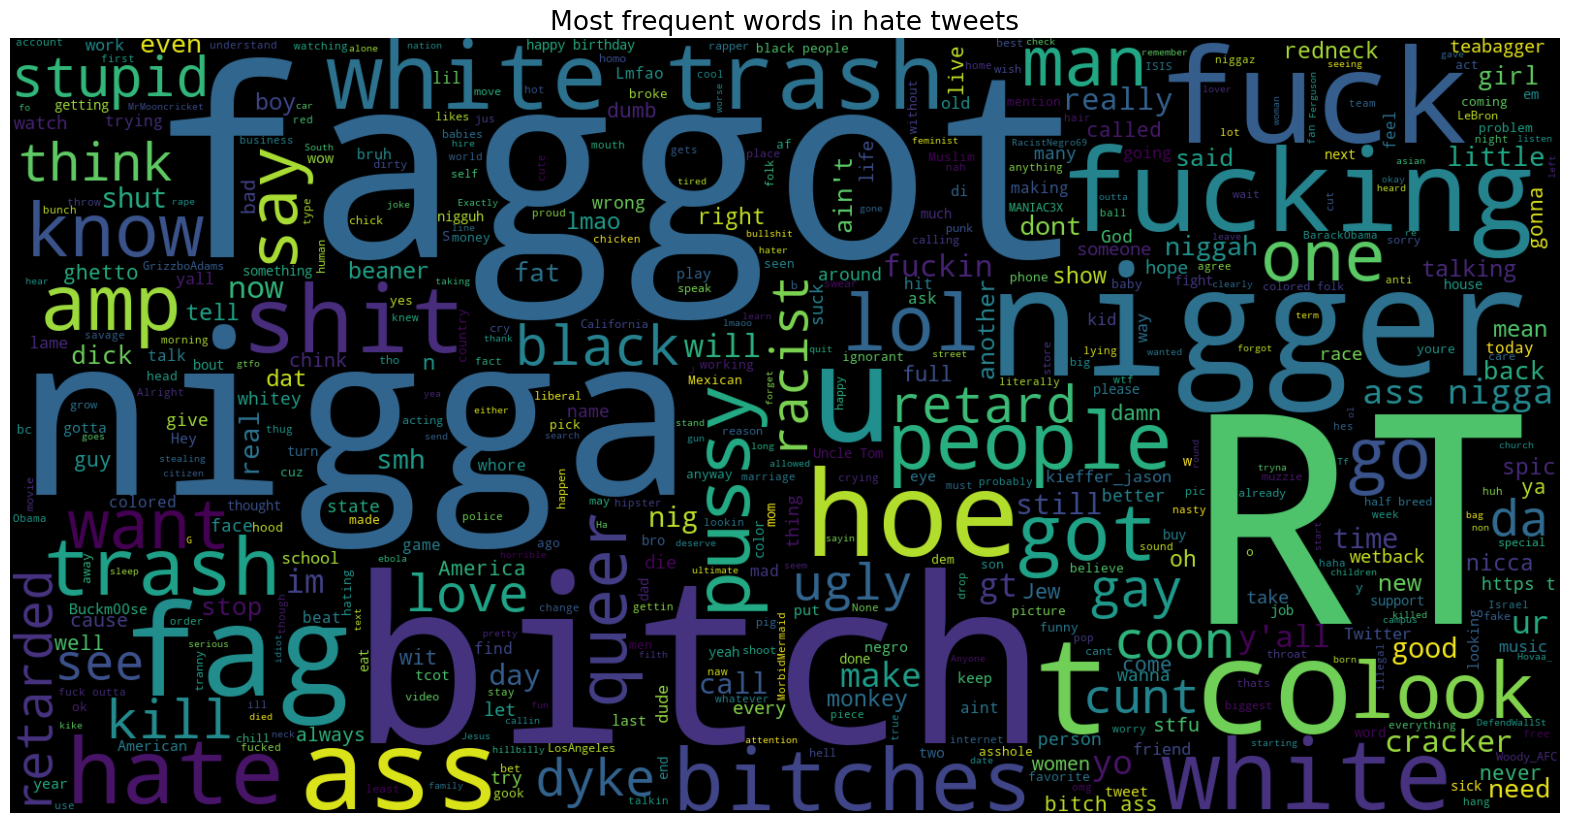

In [12]:
hate_tweets = df[df.labels == "Hate Speech"]
hate_tweets.head()
text = ' '.join([word for word in hate_tweets['tweet']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most frequent words in hate tweets', fontsize = 19)
plt.show()

## Data Preprocessing

In [13]:
# Define preprocessing function
def preprocess_tweet(tweet):
    # Convert text to lowercase
    tweet = tweet.lower()
    # Remove URLs
    tweet = re.sub(r'http\S+', '', tweet)
    # Remove punctuation
    tweet = re.sub(r'[^\w\s]', '', tweet)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(tweet)
    filtered_tweet = [word for word in word_tokens if word not in stop_words]
    # Join tokens back into a single string
    processed_tweet = ' '.join(filtered_tweet)
    return processed_tweet

# Apply preprocessing to the 'tweet' column of the dataset
df['tweet'] = df['tweet'].apply(preprocess_tweet)

print(df.head())

                                               tweet  \
0  rt mayasolovely woman shouldnt complain cleani...   
1  rt mleew17 boy dats coldtyga dwn bad cuffin da...   
2  rt urkindofbrand dawg rt 80sbaby4life ever fuc...   
3        rt c_g_anderson viva_based look like tranny   
4  rt shenikaroberts shit hear might true might f...   

                          labels  
0  No Hate or Offensive Language  
1             Offensive Language  
2             Offensive Language  
3             Offensive Language  
4             Offensive Language  


C:\Users\intel\AppData\Local\Temp\ipykernel_14972\1722263975.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tweet'] = df['tweet'].apply(preprocess_tweet)


## Extracting Features From the Preprocessed Data

### Bag-of-Words Approach

In [14]:
# Create a CountVectorizer object
vectorizer = CountVectorizer()

# Fit and transform the tweet column to create a BoW representation
bow_features = vectorizer.fit_transform(df['tweet'])

# Display the BoW features
bow_features.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

## Models for Training

In [15]:
X = np.array(df["tweet"])
y = np.array(df["labels"])

Firstly, we have stored our features and target values in a variable X and Y respectively.

### Support Vector Machines (SVM)

In [16]:
# Create a CountVectorizer object
vectorizer = CountVectorizer()

# Fit and transform the clean_text column to create a Bag-of-Words representation
X_bow = vectorizer.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_bow, y, test_size=0.2, random_state=42)

# Initialize and train the Support Vector Machines (SVM) model
svm = SVC(kernel='linear', random_state=42)
svm.fit(X_train, y_train)

# Predict the labels for the test set
y_pred = svm.predict(X_test)

# Calculate accuracy
accuracy1 = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy1)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.8872301795440791

Classification Report:
                               precision    recall  f1-score   support

                  Hate Speech       0.39      0.30      0.34       290
No Hate or Offensive Language       0.83      0.85      0.84       835
           Offensive Language       0.93      0.94      0.93      3832

                     accuracy                           0.89      4957
                    macro avg       0.72      0.70      0.70      4957
                 weighted avg       0.88      0.89      0.88      4957



### Decision Tree Classifier

In [17]:
# Initialize and train the Decision Tree Classifier model
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, y_train)

# Predict the labels for the test set
y_pred = decision_tree.predict(X_test)

# Calculate accuracy
accuracy2 = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy2)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.8807746620940085

Classification Report:
                               precision    recall  f1-score   support

                  Hate Speech       0.37      0.32      0.34       290
No Hate or Offensive Language       0.80      0.87      0.83       835
           Offensive Language       0.93      0.93      0.93      3832

                     accuracy                           0.88      4957
                    macro avg       0.70      0.71      0.70      4957
                 weighted avg       0.88      0.88      0.88      4957



### Random Forest Classifier

In [29]:
# Initialize and train the Random Forest model
random_forest = RandomForestClassifier()
random_forest.fit(X_train, y_train)

# Predict the labels for the test set
y_pred = random_forest.predict(X_test)

# Calculate accuracy
accuracy3 = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy3)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.8835989509784143

Classification Report:
                               precision    recall  f1-score   support

                  Hate Speech       0.51      0.27      0.35       290
No Hate or Offensive Language       0.84      0.76      0.80       835
           Offensive Language       0.91      0.96      0.93      3832

                     accuracy                           0.88      4957
                    macro avg       0.75      0.66      0.69      4957
                 weighted avg       0.87      0.88      0.87      4957



### Naive Bayes

In [20]:
# Initialize and train the Naive Bayes classifier
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)

# Predict the labels for the test set
y_pred = nb_classifier.predict(X_test)

# Calculate accuracy
accuracy4 = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy4)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.8620133145047407

Classification Report:
                               precision    recall  f1-score   support

                  Hate Speech       0.36      0.08      0.13       290
No Hate or Offensive Language       0.83      0.62      0.71       835
           Offensive Language       0.87      0.97      0.92      3832

                     accuracy                           0.86      4957
                    macro avg       0.69      0.56      0.59      4957
                 weighted avg       0.84      0.86      0.84      4957



### Logistic regression

In [21]:
# Initialize and train the logistic regression model
logistic_reg = LogisticRegression(max_iter=1000)
logistic_reg.fit(X_train, y_train)

# Predict the labels for the test set
y_pred = logistic_reg.predict(X_test)

# Calculate accuracy
accuracy5 = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy5)

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.8967117207988703

Classification Report:
                               precision    recall  f1-score   support

                  Hate Speech       0.48      0.22      0.31       290
No Hate or Offensive Language       0.83      0.87      0.85       835
           Offensive Language       0.93      0.95      0.94      3832

                     accuracy                           0.90      4957
                    macro avg       0.75      0.68      0.70      4957
                 weighted avg       0.88      0.90      0.89      4957



## Results

In [34]:
sample = " India should become Hindu nation "
sample = preprocess_tweet(sample)
data1 = vectorizer.transform([sample]).toarray()

In [35]:
# Prediction through SVM Model
svm.predict(data1)

array(['No Hate or Offensive Language'], dtype=object)

In [36]:
# Prediction through Decision Tree Classifier Model
decision_tree.predict(data1)

array(['No Hate or Offensive Language'], dtype=object)

In [30]:
# Prediction through Random Forest Model
random_forest.predict(data1)

array(['Offensive Language'], dtype=object)

In [27]:
# Prediction through Naive Bayes Model
nb_classifier.predict(data1)

array(['Offensive Language'], dtype='<U29')

In [28]:
# Prediction through Logistic Regression Model
logistic_reg.predict(data1)

array(['Offensive Language'], dtype=object)

## Comparision Between The Models Performance

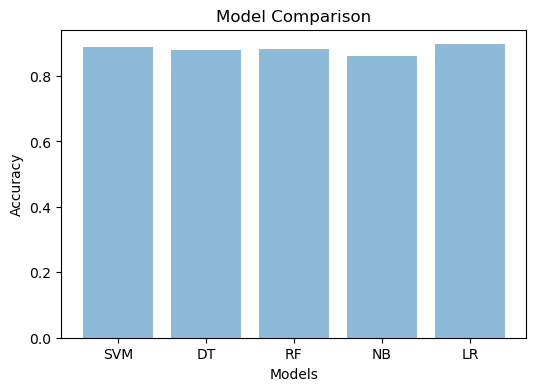

In [31]:
# Sample data representing different models' accuracy
objects = ('SVM', 'DT', 'RF', 'NB', 'LR')

# Assuming accuracy1, accuracy2, accuracy3, accuracy4, accuracy5 are defined earlier
performance = [accuracy1, accuracy2, accuracy3, accuracy4, accuracy5]

# Set the figure size (width, height) in inches
plt.figure(figsize=(6, 4))  # Adjust the width and height as needed

# Plotting the bar chart
y_pos = np.arange(len(objects))
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Accuracy')
plt.xlabel('Models')
plt.title('Model Comparison')
plt.show()

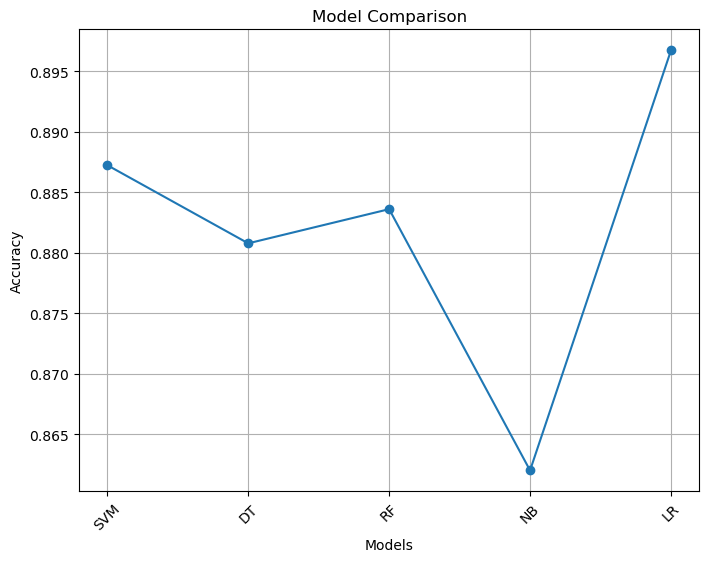

In [32]:
# Set the figure size (width, height) in inches
plt.figure(figsize=(8, 6))  # Adjust the width and height as needed

# Sample data representing different models' accuracy
objects = ('SVM', 'DT', 'RF', 'NB', 'LR')

# Assuming accuracy1, accuracy2, accuracy3, accuracy4, accuracy5 are defined earlier
performance = [accuracy1, accuracy2, accuracy3, accuracy4, accuracy5]

# Plotting the line chart
plt.plot(objects, performance, marker='o', linestyle='-')

# Add labels and title
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Model Comparison')

# Show grid
plt.grid(True)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show plot
plt.show()


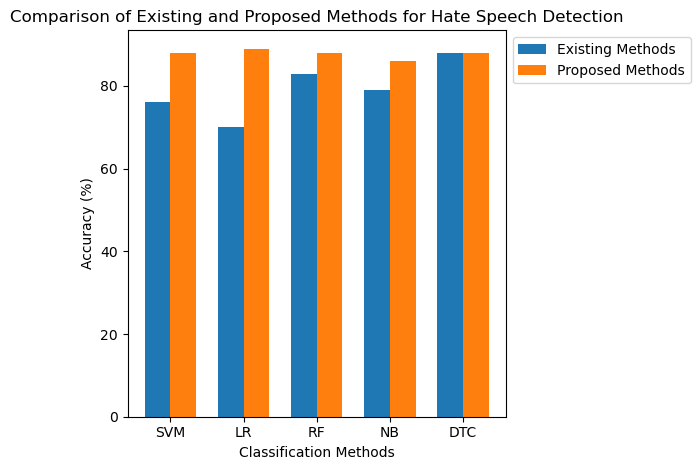

In [33]:
import matplotlib.pyplot as plt

# Data
existing_methods = ['SVM', 'LR', 'RF', 'NB', 'DTC']
existing_accuracy = [76, 70, 83, 79, 88]

proposed_accuracy = [88, 89, 88, 86, 88]

# Plotting
bar_width = 0.35
index = range(len(existing_methods))

plt.bar(index, existing_accuracy, bar_width, label='Existing Methods')
plt.bar([i + bar_width for i in index], proposed_accuracy, bar_width, label='Proposed Methods')

plt.xlabel('Classification Methods')
plt.ylabel('Accuracy (%)')
plt.title('Comparison of Existing and Proposed Methods for Hate Speech Detection')
plt.xticks([i + bar_width / 2 for i in index], existing_methods)

# Move the legend to the upper left corner outside the plot area
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')

plt.tight_layout()
plt.show()

